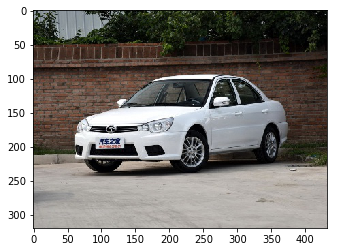

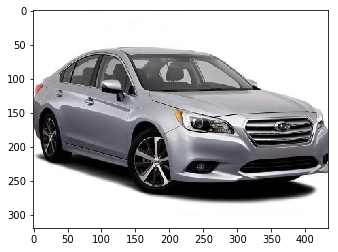

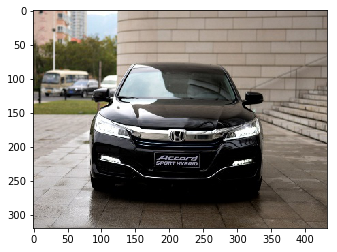

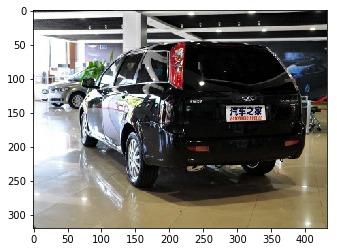

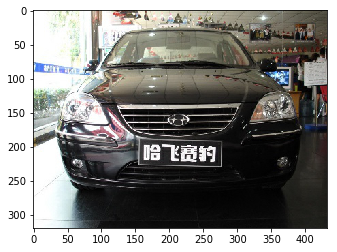

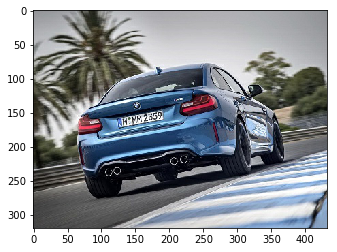

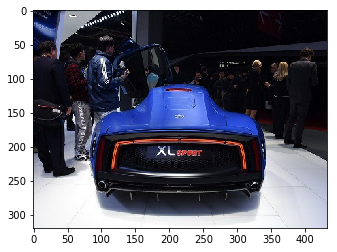

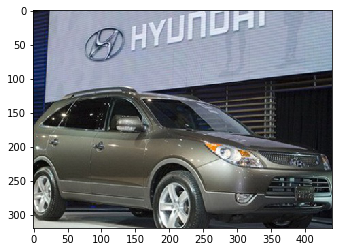

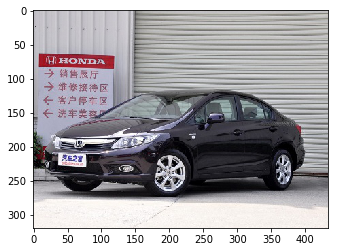

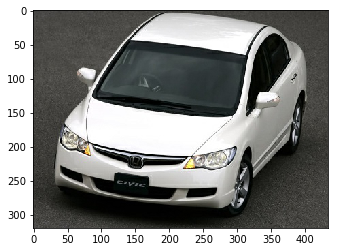

In [4]:
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
import os

# 加载 TFRecord 文件
tf_record_filename_queue = tf.train.string_input_producer(
    tf.gfile.Glob(os.path.join("dataset/data_cars/pj_vehicle_train_00001-of-00004.tfrecord")), shuffle=True)

# 注意这个不同的记录读取器，它的设计意图是能够使用可能会包含多个样本的 TFRecord 文件
tf_record_reader = tf.TFRecordReader()
_, tf_record_serialized = tf_record_reader.read(tf_record_filename_queue)

# 标签和图像都按字节存储，但也可按 int64 或 float64 类型存储于序列化的 tf.Example protobuf 文件中
tf_record_features = tf.parse_single_example(
    tf_record_serialized, features={
        'image/encoded': tf.FixedLenFeature([], tf.string), 
        'image/width': tf.FixedLenFeature([], tf.int64), 
        'image/height': tf.FixedLenFeature([], tf.int64), 
        'image/format': tf.FixedLenFeature([], tf.string), 
        'image/class/label': tf.FixedLenFeature([], tf.int64), 
    })

# 使用 tf.uint8 类型，因为所有的通道信息都处于 0~255
tf_record_image = tf.image.decode_jpeg(tf_record_features['image/encoded'], channels=3)

tf_record_width = tf.cast(tf_record_features['image/width'], tf.int32)
tf_record_height = tf.cast(tf_record_features['image/height'], tf.int32)
tf_record_label = tf.cast(tf_record_features['image/class/label'], tf.int32)

with tf.Session() as sess:
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    # 启动多线程
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    for i in range(100):
        plt.imshow(tf_record_image.eval())
        plt.show()
        single, lbl, width, height = sess.run([tf_record_image, tf_record_label, tf_record_width, tf_record_height])
        img = Image.fromarray(single, 'RGB')
        img.save('data_jpg' + str(i) + '_' + str(width) + 'x' + str(height) + '_Label_' + str(lbl) + '.jpg')
        
    coord.request_stop()
    coord.join(threads)